
#### Teoría de Circuitos II

### 2023

#  Trabajo Práctico Laboratorio 2: Filtros digitales

#### Grupo 2

#### Curso: R4052

#### Autor: Federico Rodriguez Vizzon


## Consigna

Diseñar por softaware filtros digitales que cumplan con las especificaciones para luego implementarlos utilizando un LPC1769 y la libreria CMSIS.


<img src="./assets/spec.png" align="center" width = "800"/> 



## Etapa 1: Diseño de los filtros

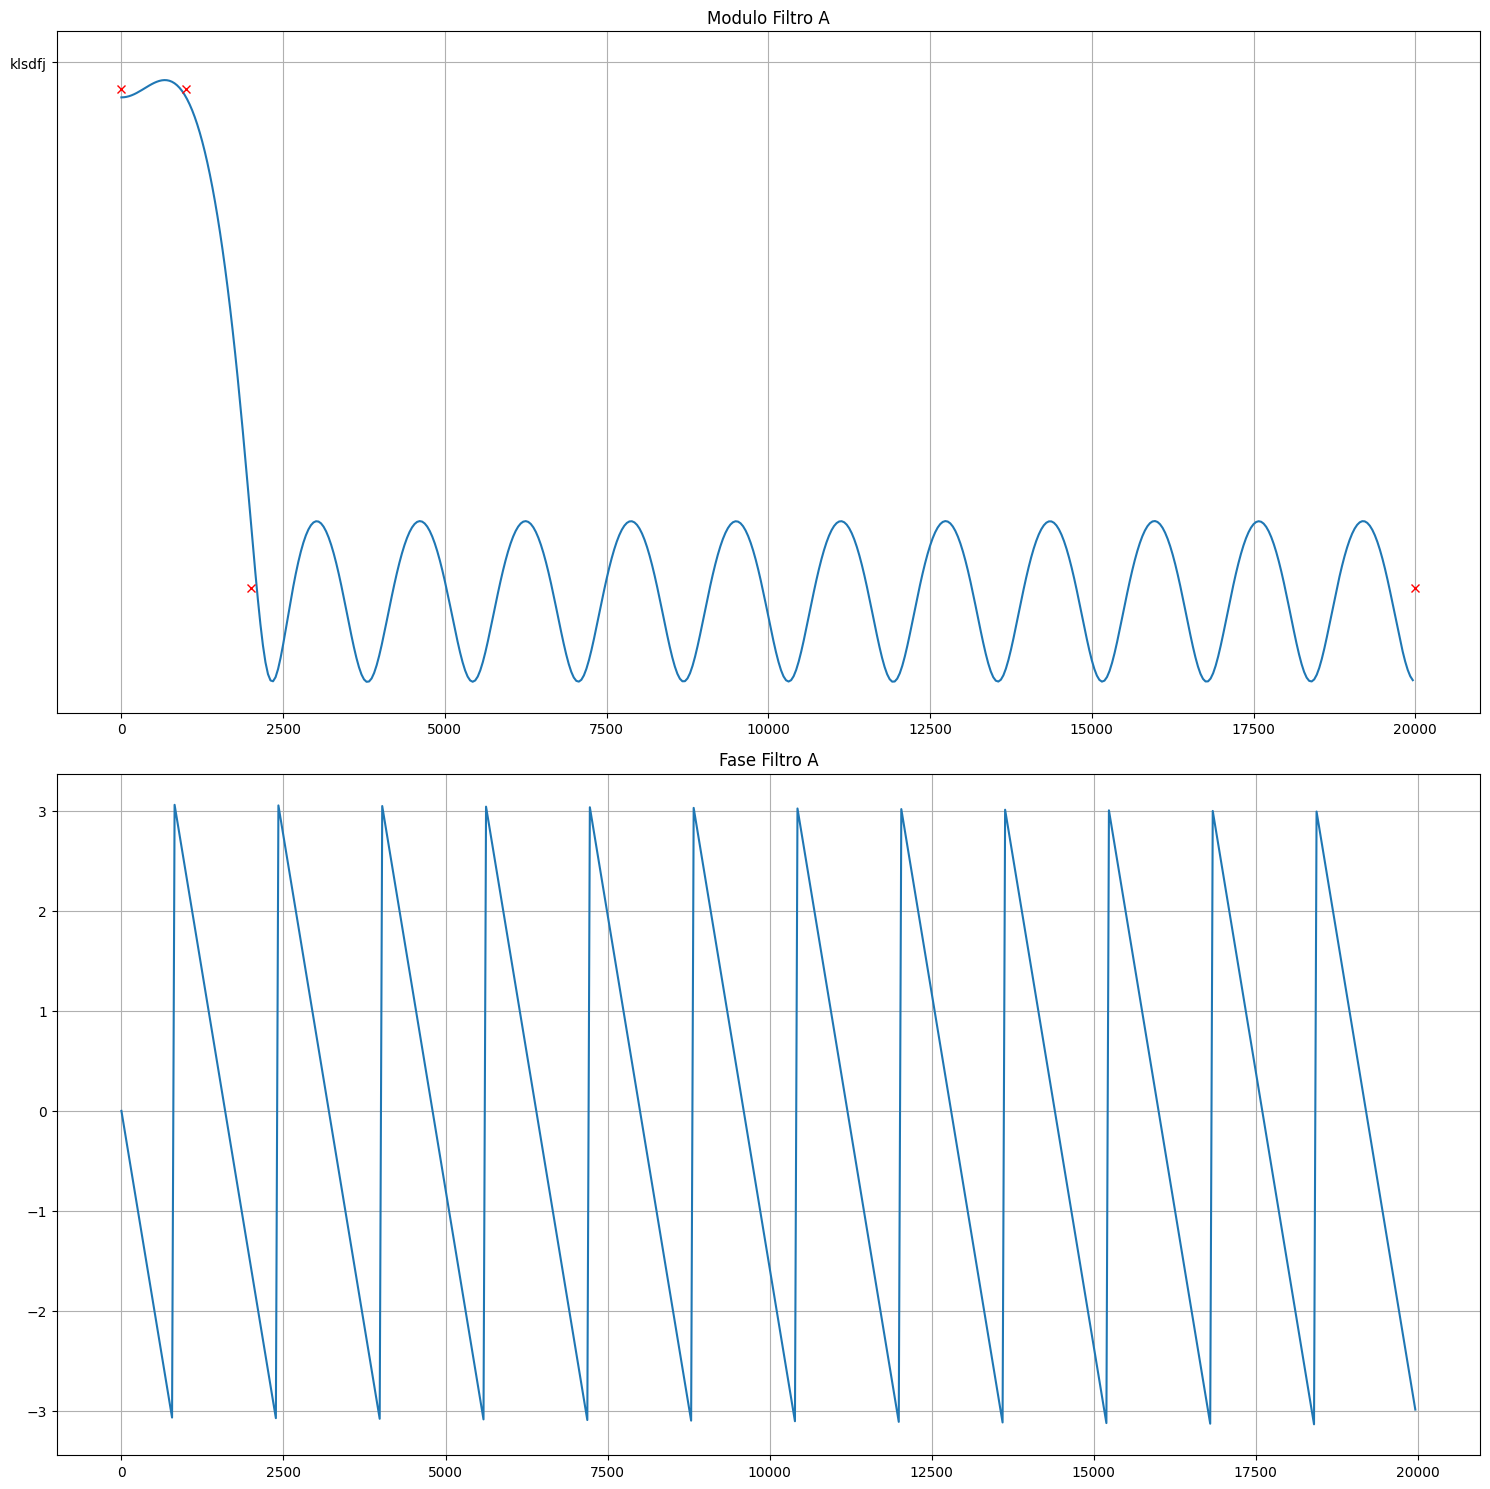

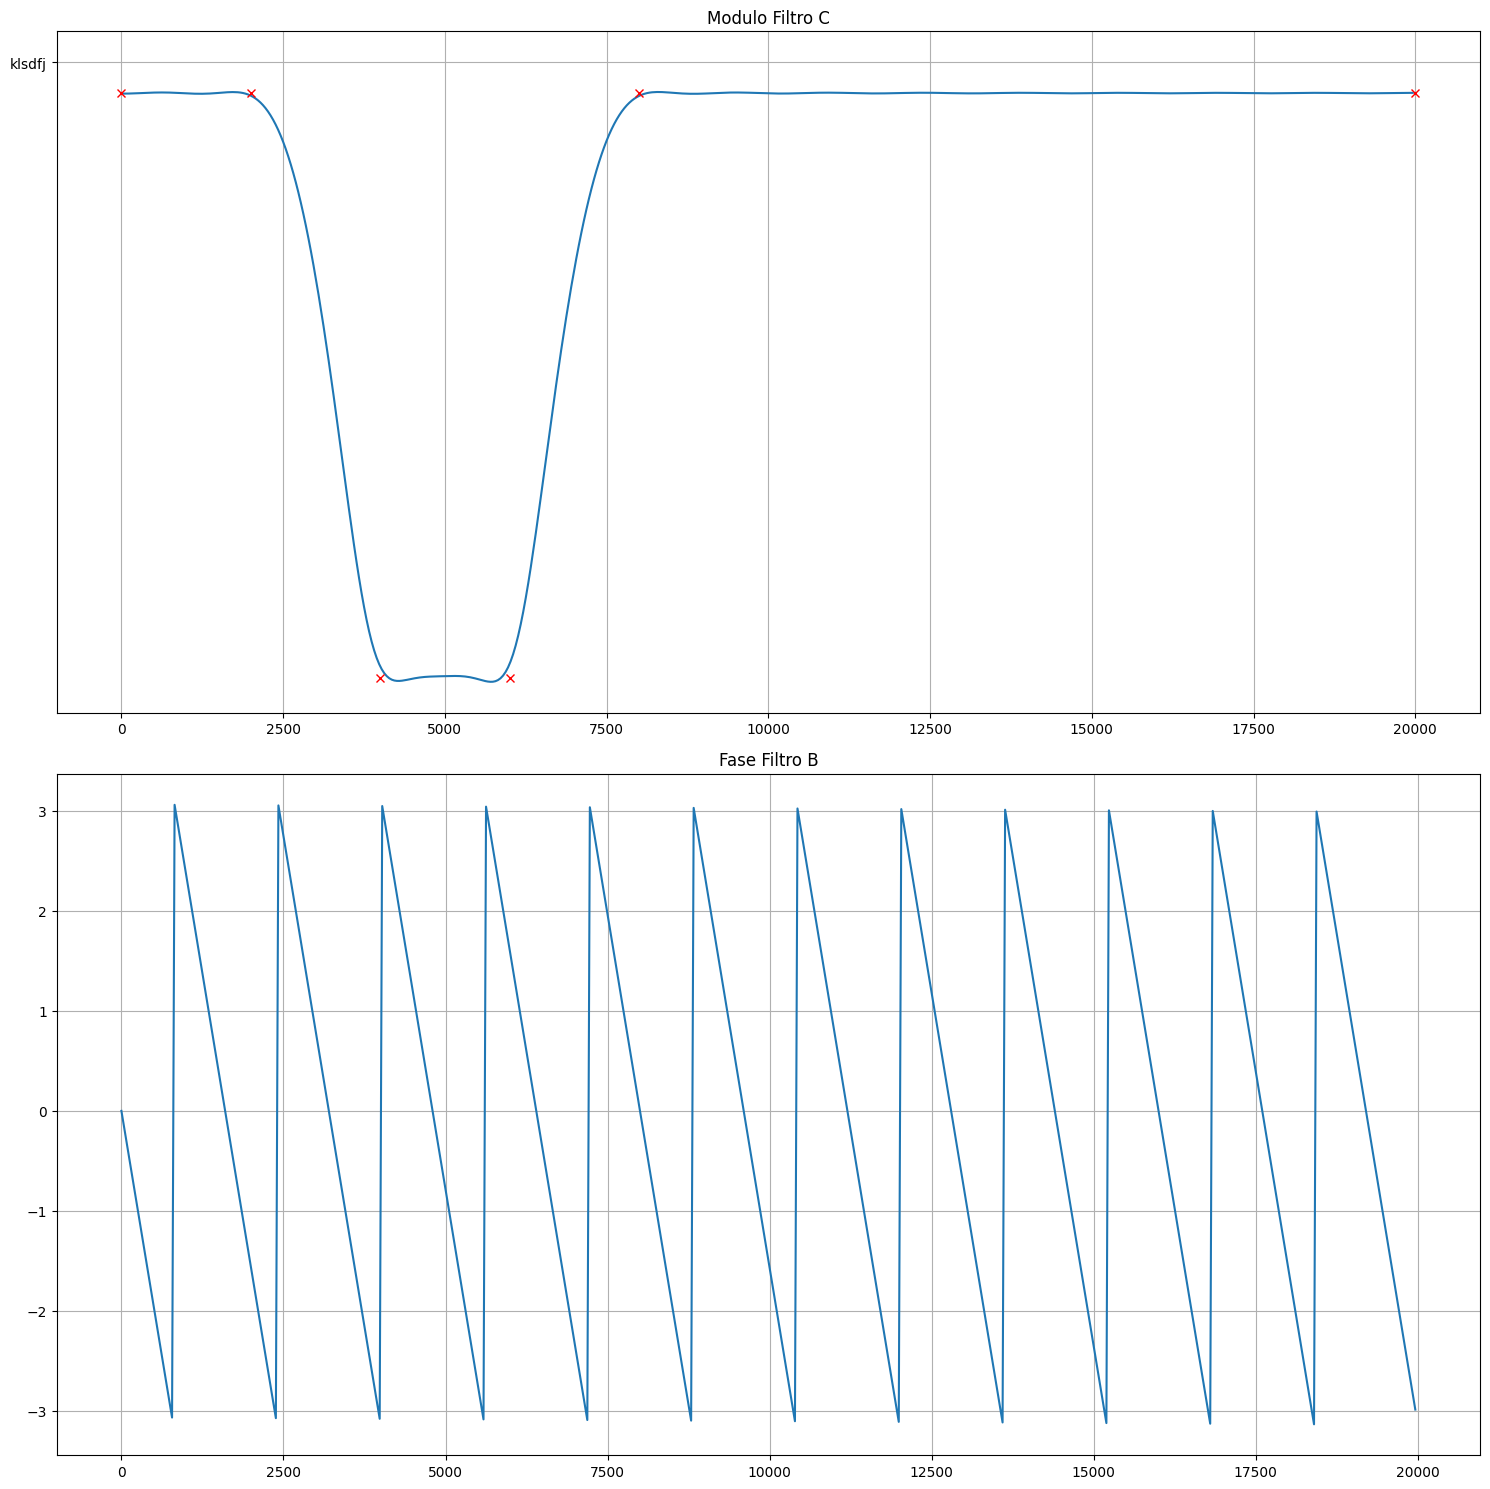

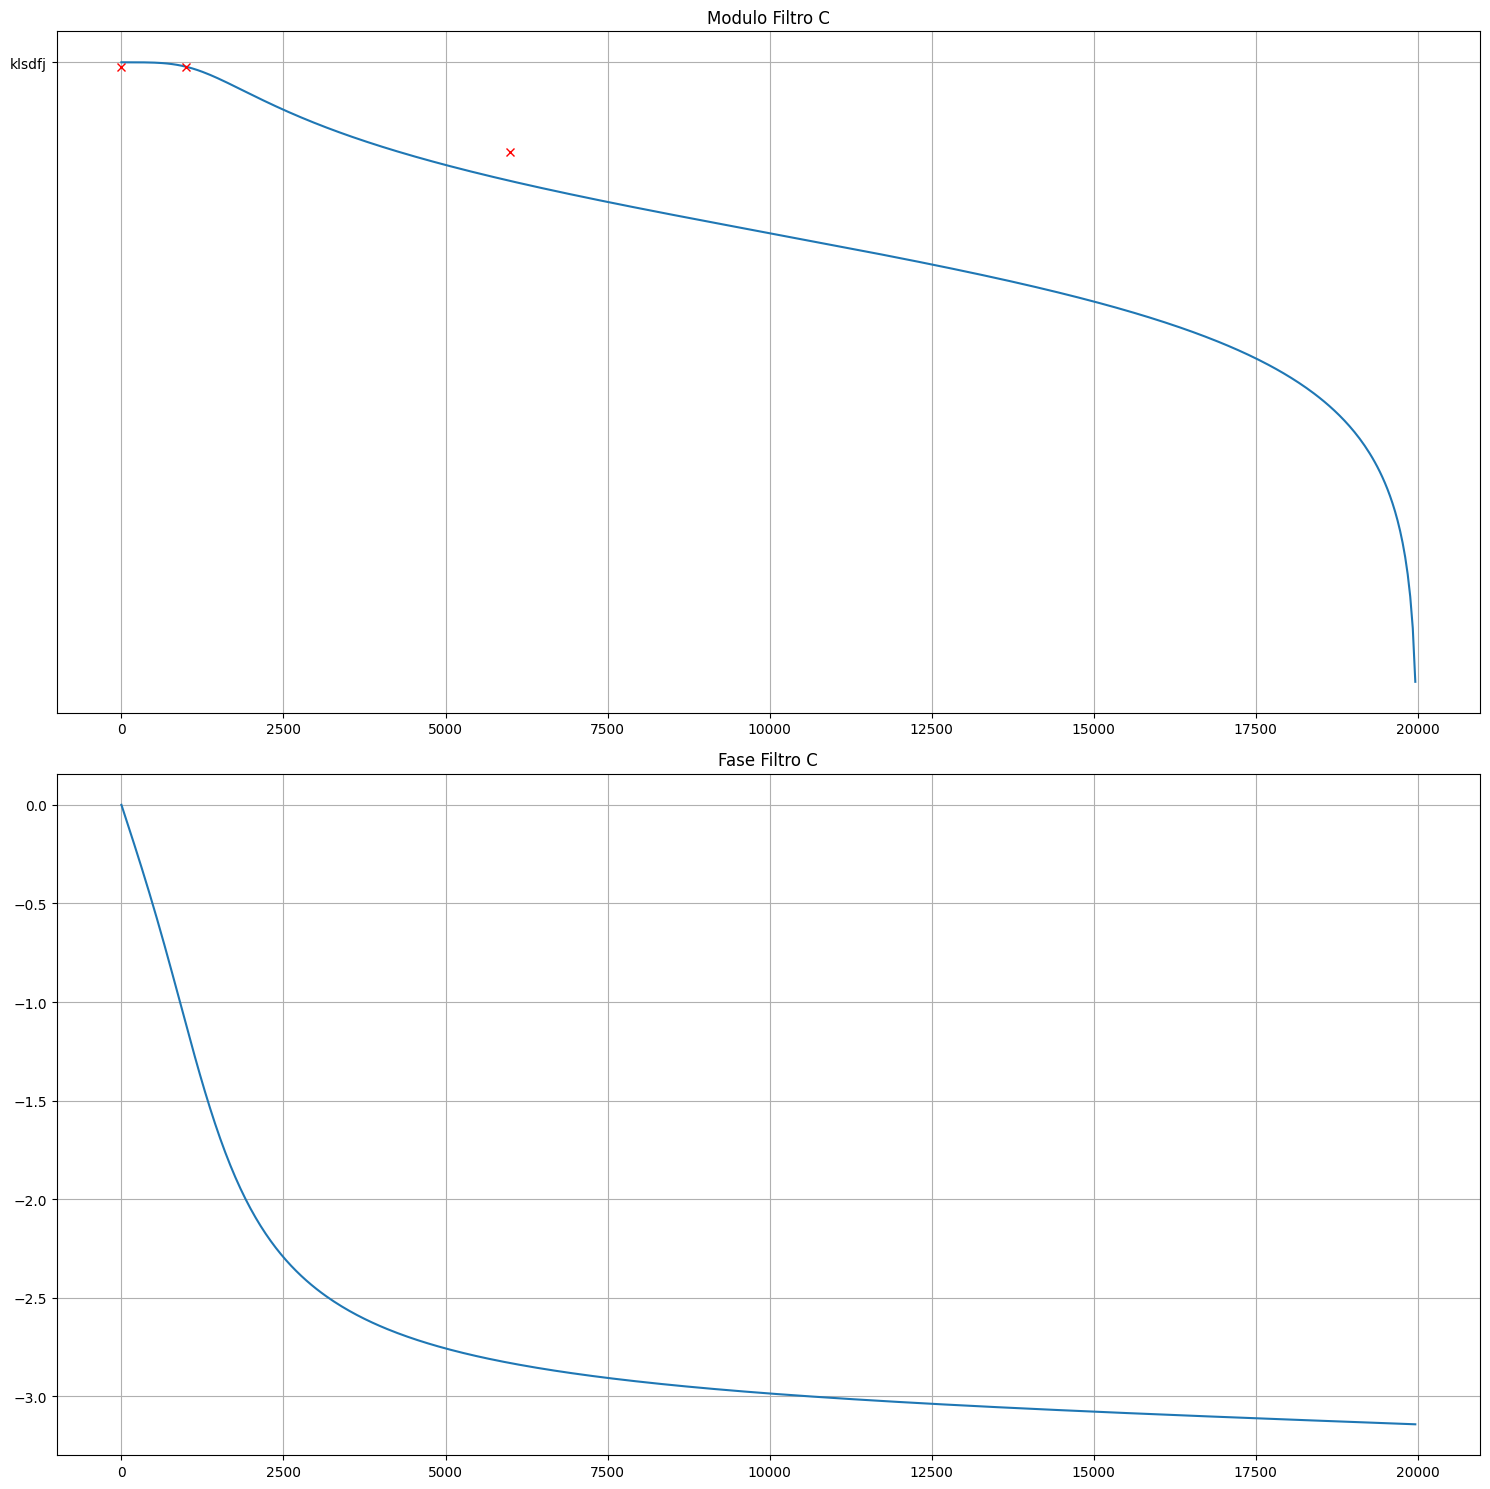

In [72]:
from numpy import genfromtxt
from IPython.display import display, Markdown
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')
# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

############################## Nyquist
fs = 40000 # Hz
nyq_frec = fs / 2

############################## Plantilla
# filter design
alpha_min = 20
alpha_max = 1

############################# FILTRO A 
# LP equi ripple FIR
taps_a = 51
frecs_a = [0, 1000, 2000, nyq_frec]
gains_db_a = [-alpha_max, -alpha_min]
gains_db_a_2 = [-alpha_max, -alpha_max ,-alpha_min, -alpha_min]
gains_vs_a = 10**(np.array(gains_db_a)/20)
num_a = sig.remez(taps_a, frecs_a, gains_vs_a, fs=fs)
wz_a, hz_a = sig.freqz(num_a, 1.0)

############################# FILTRO B
# Stop Band
taps_b = 51
frecs_b = [0, 2000, 4000, 6000, 8000, nyq_frec]
gains_db_b = [-alpha_max, -alpha_max, -alpha_min, -alpha_min, -alpha_max, -alpha_max]
gains_vs_b = 10**(np.array(gains_db_b)/20)
num_b = sig.firls(taps_b, frecs_b, gains_vs_b, fs=fs)
wz_b, hz_b = sig.freqz(num_b, 1.0)

############################# FILTRO C
# LP IIR
frecs_c = [0, 1000, 6000, nyq_frec]
gains_db_c = [-1, -1, -20, -np.inf]
num_c, den_c = sig.iirdesign(
    wp=1000, 
    ws=6000, 
    gpass=alpha_max,
    gstop=alpha_min, 
    analog=False, 
    ftype='butter', 
    output='ba', 
    fs=fs
    )
wz_c, hz_c = sig.freqz(num_c, den_c)


### PLOT TF A
fig_a, ax_a = plt.subplots(2, 1, figsize=(15, 15))
ax_a[0].set_title("Modulo Filtro A")
ax_a[0].plot(wz_a*fs/(2*np.pi), 20*np.log10(hz_a))
ax_a[0].plot(frecs_a, gains_db_a_2, 'rx', 'klsdfj')
ax_a[0].grid()
ax_a[1].set_title("Fase Filtro A")
ax_a[1].plot(wz_a*fs/(2*np.pi), np.angle(hz_a))
ax_a[1].grid()
fig_a.tight_layout()

### PLOT TF B
fig_b, ax_b = plt.subplots(2, 1, figsize=(15, 15))
ax_b[0].set_title("Modulo Filtro C")
ax_b[0].plot(wz_b*fs/(2*np.pi), 20*np.log10(hz_b))
ax_b[0].plot(frecs_b, gains_db_b, 'rx', 'klsdfj')
ax_b[0].grid()
ax_b[1].set_title("Fase Filtro B")
ax_b[1].plot(wz_b*fs/(2*np.pi), np.angle(hz_b))
ax_b[1].grid()
fig_b.tight_layout()

### PLOT TF B
fig_c, ax_c = plt.subplots(2, 1, figsize=(15, 15))
ax_c[0].set_title("Modulo Filtro C")
ax_c[0].plot(wz_c*fs/(2*np.pi), 20*np.log10(hz_c))
ax_c[0].plot(frecs_c, gains_db_c, 'rx', 'klsdfj')
ax_c[0].grid()
ax_c[1].set_title("Fase Filtro C")
ax_c[1].plot(wz_c*fs/(2*np.pi), np.angle(hz_c))
ax_c[1].grid()
fig_c.tight_layout()

#### Etapa 2: Implementacion

Utilizando el framework provisto por la catedra corrimos los filtros sobre un LPC1769 usando la biblioteca CMSIS.

ACA va lo del LP usado como antialiazing y reconstruccion.

## Etapa 3: Validacion manual

Mediante el uso del osciloscopio levantamos los valores de $V_i$ $V_o$ y medimos el tiempo entre los picos de maximo valor de las señales para poder calcular la respuesta de fase de la funcion transferencia.

[  1.3066462    1.06057055   0.1697622   -2.22912457  -5.60264143
 -12.1738114 ]


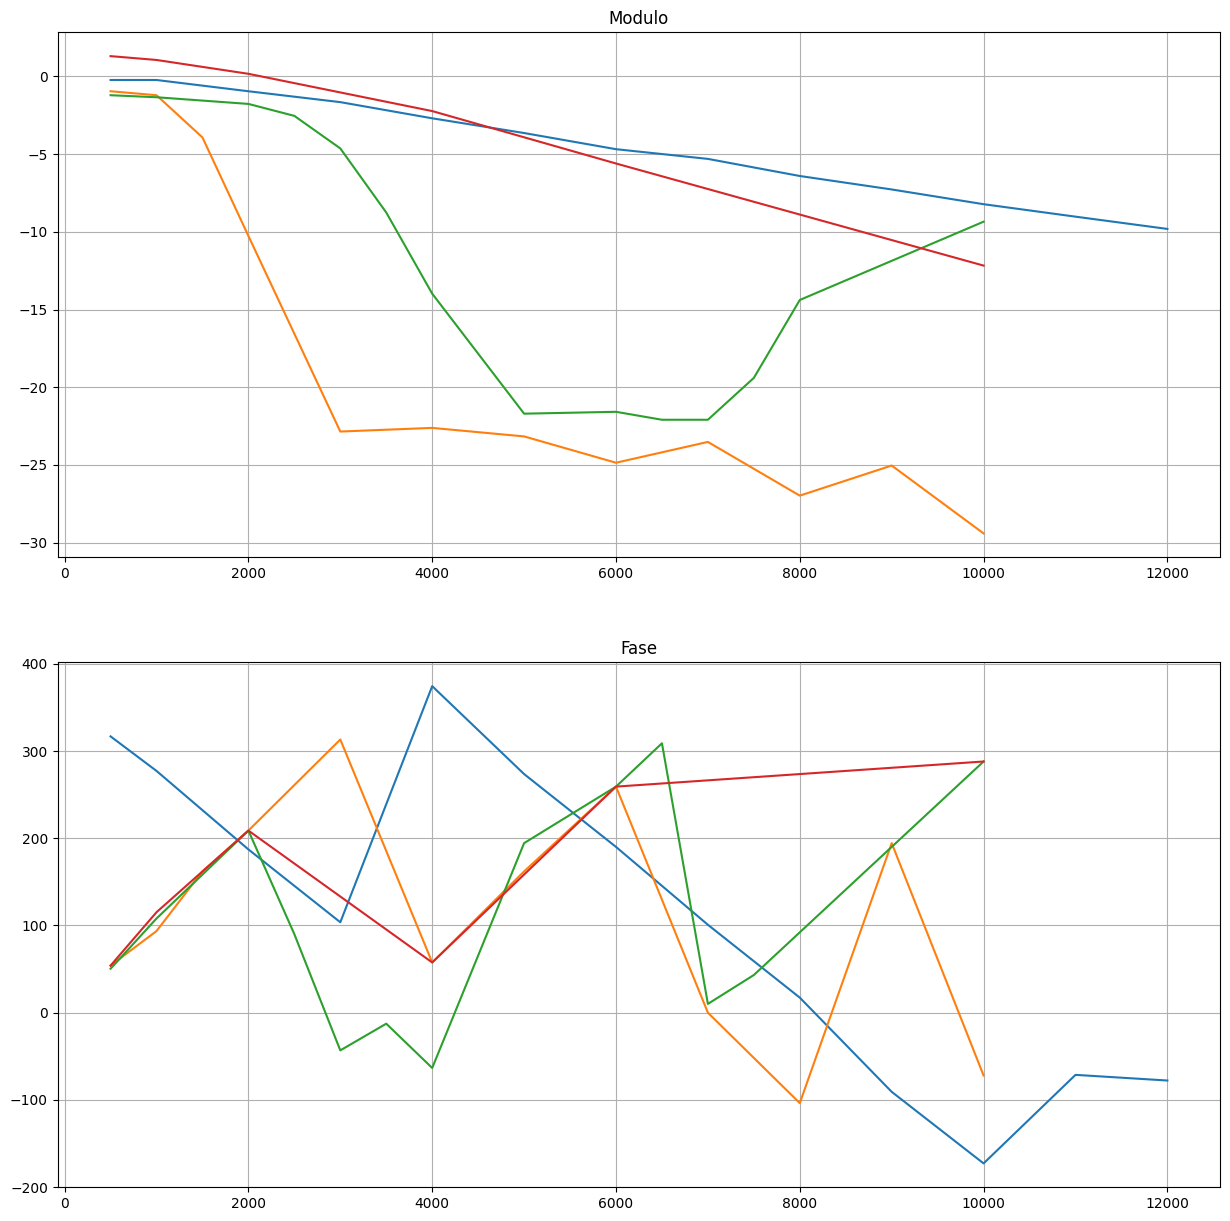

In [63]:
######################### Mediciones Manuales.
# Modulo y retrazo de senales en modo talkThrough
freqs_base_line = np.array([500,     1000,   2000,   3000,  4000,   5000,   6000,  7000,  8000, 9000,   10000,  11000, 12000])
times_base_line = np.array([1.76e-3, 770e-6, 260e-6, 96e-6, 260e-6, 152e-6, 88e-6, 40e-6, 6e-6, -28e-6, -48e-6, -18e-6, -18e-6])
vi_base_line = np.array([3.08, 3.08, 3.08, 3, 3, 2.92, 2.88, 2.8, 2.76, 2.68, 2.68, 2.6,  2.6])
vo_base_line = np.array([3, 3, 2.76, 2.48, 2.20, 1.92, 1.68, 1.52, 1.32, 1.16, 1.04, 0.92, 0.84])
phase_base_line = np.multiply(np.array(360*freqs_base_line), times_base_line)

# Modulo y retrazo para el filtro A
freqs_filter_a = np.array([500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
vi_filter_a = np.array(   [3.08, 3.08, 3.08, 3,    3,     2.92,  2.88, 2.8,  2.76,  2.68,  2.68, 2.6])
vo_filter_a = np.array(   [2.76, 2.68, 1.96, 0.92, 0.216, 0.216, 0.2,  0.16, 0.184, 0.12,  0.15, 0.088])
times_filter_a = np.array([300e-6, 260e-6, 300e-6, 290e-6, 290e-6, 40e-6, 90e-6, 120e-6, 0, -36e-6, 60e-6, -20e-6])
phase_filter_a = np.multiply(np.array(360*freqs_filter_a), times_filter_a)

# Modulo y retrazo para el filtro B
freqs_filter_b = np.array([500,    1000,   2000,   2500,   3000,   3500,   4000,   5000,   6000,   6500,  7000, 7500,   8000, 10000])
vi_filter_b = np.array(   [3.08,   3.08,   3.04,   3,      3,      2.96,   3,      2.92,   2.88,   2.8,    2.8,  2.8,   2.62,  2.64])
vo_filter_b = np.array(   [2.68,   2.64,    2.48,   2.24,   1.76,   1.08,   0.6,    0.24,   0.24,   0.22,  0.22, 0.3,   0.5,   0.9 ])
times_filter_b = np.array([280e-6, 300e-6, 290e-6, 100e-6, -40e-6, -10e-6, -44e-6, 108e-6, 120e-6, 132e-6, 4e-6, 16e-6, 32e-6, 80e-6])
phase_filter_b = np.multiply(np.array(360*freqs_filter_b), times_filter_b)

# Modulo y retrazo para el filtro C
freqs_filter_c = np.array([500,    1000,   2000,   4000,  6000,   10000])
vi_filter_c = np.array(   [3.08,   3.08,   3.04,   2.96,  2.84,   2.64])
vo_filter_c = np.array(   [3.58,   3.48,   3.1,    2.29,  1.49,   0.65])
times_filter_c = np.array([300e-6, 320e-6, 290e-6, 40e-6, 120e-6, 80e-6])
phase_filter_c = np.multiply(np.array(360*freqs_filter_c), times_filter_c)

amp_base_line = 20*np.log10(vo_base_line/vi_base_line)
amp_filter_a = 20*np.log10(vo_filter_a/vi_filter_a)
amp_filter_b = 20*np.log10(vo_filter_b/vi_filter_b)
amp_filter_c = 20*np.log10(vo_filter_c/vi_filter_c)

fig_man_1, ax_man_1 =  plt.subplots(2, 1, figsize = (15, 15))
ax_man_1[0].set_title('Modulo')
ax_man_1[0].plot(freqs_base_line, amp_base_line, label='Transferencia en vacio')
ax_man_1[0].plot(freqs_filter_a, amp_filter_a, label='Transferencia Filtro A')
ax_man_1[0].plot(freqs_filter_b, amp_filter_b, label='Transferencia Filtro B')
ax_man_1[0].plot(freqs_filter_c, amp_filter_c, label='Transferencia Filtro C')
ax_man_1[0].grid()
ax_man_1[1].set_title('Fase')
ax_man_1[1].plot(freqs_base_line, phase_base_line, label='Fase en vacio')
ax_man_1[1].plot(freqs_filter_a, phase_filter_a, label='Fase Filtro A')
ax_man_1[1].plot(freqs_filter_b, phase_filter_b, label='Fase Filtro B')
ax_man_1[1].plot(freqs_filter_c, phase_filter_c, label='Fase Filtro C')
ax_man_1[1].grid()

## Etapa 4: Validacion utlizando un analizador de audio

Luego de haber obtenido una respuesta aproximada de la respuesta en modulo de cada uno de los 3 filtros y que confirmamos que las implementaciones responden acorde a lo esperado ensayamos los filtros con un analizador de audio.

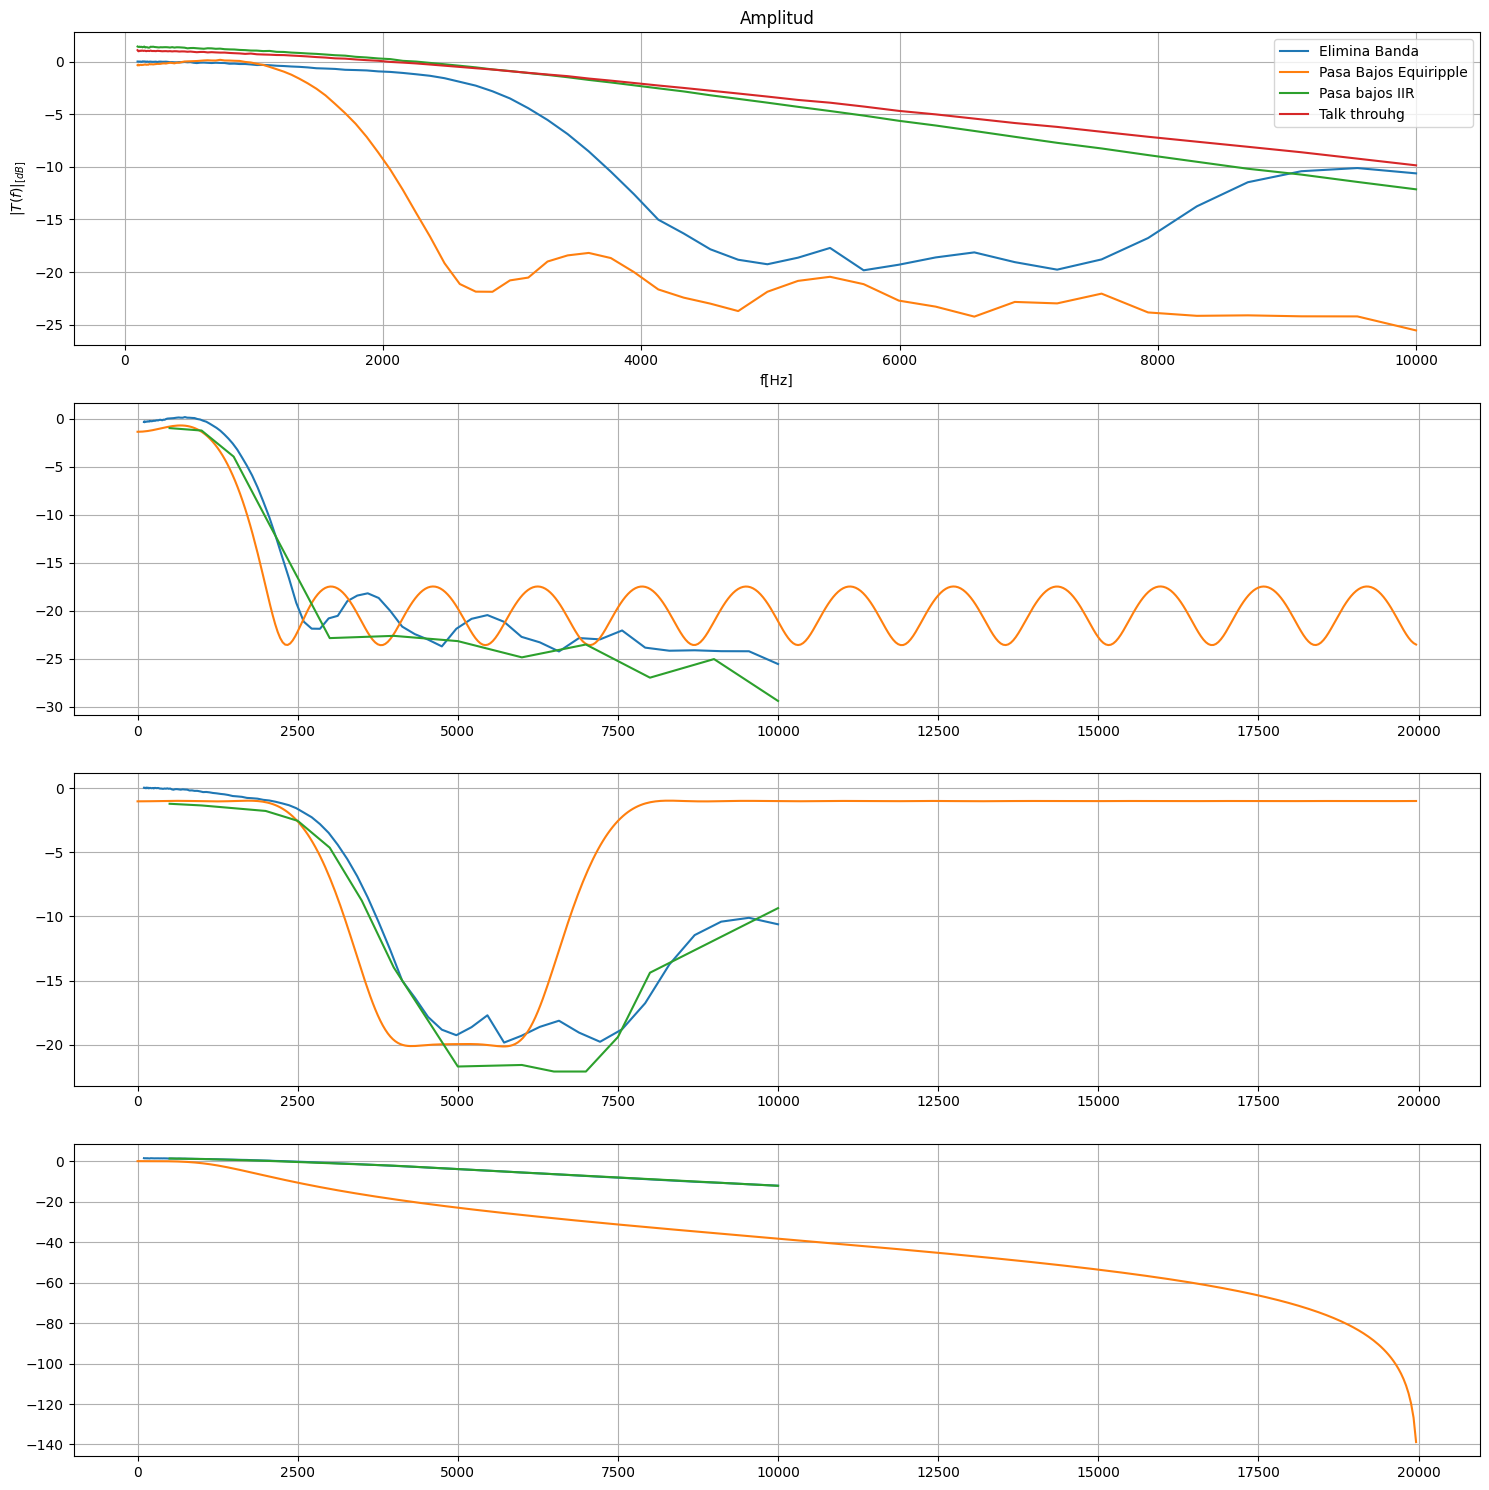

In [71]:
#levantamos los valores de modulo (previeamente descartamos el header y otro relleno del csv.)
# TODO obtener los valores con el analizado de audio y plotearlos junto a los valores obtenidos manualmente.
raw_data_0 = genfromtxt('csv/raw_data_0.csv', delimiter = ',') 
raw_data_1 = genfromtxt('csv/raw_data_1.csv', delimiter = ',')
raw_data_2 = genfromtxt('csv/raw_data_2.csv', delimiter = ',')
raw_data_3 = genfromtxt('csv/raw_data_3.csv', delimiter = ',')

freq_0 = raw_data_0[:,0]
mod_0 = raw_data_0[:,1]
freq_1 = raw_data_1[:,0]
mod_1 = raw_data_1[:,1]
freq_2 = raw_data_2[:,0]
mod_2 = raw_data_2[:,1]
freq_3 = raw_data_3[:,0]
mod_3 = raw_data_3[:,1]

#configuramos la cantidad de graficos, 3 filas 1 columna
figure, axes = plt.subplots(4,1, figsize=(15, 15))
axes[0].plot(freq_0, mod_0)
axes[0].plot(freq_1, mod_1)
axes[0].plot(freq_2, mod_2)
axes[0].plot(freq_3, mod_3)
axes[0].set_ylabel(r'$|T(f)|_{[dB]}$')
axes[0].set_xlabel('f[Hz]')
axes[0].grid()
axes[0].set_title("Amplitud")
axes[0].legend(["Elimina Banda","Pasa Bajos Equiripple", "Pasa bajos IIR", "Talk throuhg"])
axes[1].plot(freq_1, mod_1, wz_a*fs/(2*np.pi), 20*np.log10(hz_a), freqs_filter_a, amp_filter_a)
axes[1].grid()
axes[2].plot(freq_0, mod_0, wz_b*fs/(2*np.pi), 20*np.log10(hz_b), freqs_filter_b, amp_filter_b)
axes[2].grid()
axes[3].plot(freq_2, mod_2, wz_c*fs/(2*np.pi), 20*np.log10(hz_c), freqs_filter_c, amp_filter_c)
axes[3].grid()
#limitamos el grafico a los valores de frecuencia disponibles.
#axes[0].set_xlim([x_0_lower_limit, x_0_upper_limit])
#no limitamos en y, la libreria lo esta resolviendo mejor que nosotros.
#axes[0].set_ylim([y_0_lower_limit, y_0_upper_limit])
figure.tight_layout()


## Conclusiones: SON DEL TPL1

### Amplitud
La curva obtenida en forma manual hasta llegar a $f_o$ es muy similar a la obtenida en la simulacion numérica, pero al ir de $f_o$ hacia $\infty$ se tomaron menos puntos y la interpolacion denota muchos errores al momento de graficar la respuesta en amplitud del filtro implementado. 
En el punto central, se aprecia una atenuación similar a la obtenida con el cálculo numérico 30db pero muy inferior a la simulada en spice 63db.

Cuando nos acercabamos a la frecuencia central, el ruido medido por el osciloscopio se volvia notorio y dificultaba la medición.

Con el analizador de audio, la atenuación en $f_o$ es considerablemente menor a la ideal (12 dB). Esto se debe a que, durante el proceso de barrido, no se tomó un punto en 50 Hz como se hizo manualmente; el punto más cercano es 51,48 Hz.

Posteriormente, se llevó a cabo un segundo barrido centrado en la zona próxima a la frecuencia de interés, abarcando desde 40 Hz hasta 60 Hz. Se obtuvo una respuesta que se acerca a la ideal, sin embargo, lamentablemente, los datos no fueron almacenados. En la imagen siguiente se muestra la respuesta obtenida durante este segundo barrido.


<img src="./assets/audio_module.jpeg" align="center"/>


### Fase
Al momento de seleccionar los puntos en los que se iba a medir, se le dio mucho peso a la respuesta en amplitud, y esto tiene como consecuencia que la curva de fase sea abrupta y esté un poco alejada de la curva ideal. Deberían haberse tomado más puntos intermedios entre los 30 Hz y los 80 Hz, que si bien desde el punto de vista de la amplitud serían "redundantes", hubieran aportado mucha información para trazar la respuesta de fase.

Realizar la medición de fase con el analizador de audio no fue una tarea trivial por las siguientes razones:

Para frecuencias menores a 20 Hz, la fase oscilaba entre 180° y -180°.
Al llegar a 50 Hz, que es donde se produce el salto de fase, los valores de fase superaban la escala del instrumento y se obtenían valores menores.
La gráfica de fase obtenida por el equipo quedó de la siguiente forma.

<img src="./assets/audio_phase.jpeg" align="center"/>

Para poder graficar correctamente la fase, fue necesario corregir sus valores después de la medición.


### Retardo de grupo

Los errores cometidos al medir la fase con el analizador de audio, sobre todo en baja frecuencia donde se observan picos, al calcular el retardo de grupo, generan errores aún más grandes, ya que el mismo se obtiene realizando la derivada numérica de la fase.

### Nota de aplicacion utilizada de referencia
La implementación se realizó siguiendo la nota de aplicación 746-7592, la cuál no hace ninguna aclaración sobre la respuesta de fase de la red propuesta. Al simularla, observamos que el circuito impone una fase de 180º en CC, y no de 0º en CC como la simulación numérica. Esta fase inicial complicó las mediciones con el analizador de audio y retrasó mucho la práctica en el laboratorio.

### Resultado Final
Luego de superar todos los obstáculos de medición, se pudo validar que el filtro sintetizado cumple con el requisito de diseño.

In [78]:
np.roots([1, 0, 4, 0, 3])

array([0.+1.73205081j, 0.-1.73205081j, 0.+1.j        , 0.-1.j        ])

In [74]:
1.22474487j*1.22474487j


(-1.499999996591317+0j)

In [77]:
np.sqrt(5)

2.23606797749979